In [1]:
# Imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize, stats
from astropy.table import Table
import emcee
import corner
from collections import OrderedDict
from scipy.stats import gaussian_kde
import time
from astropy import table 
from astropy.io import ascii
import astropy.io.fits as fits
from astropy.coordinates import SkyCoord
from scipy.signal import find_peaks
import uncertainties.umath as um
from uncertainties import ufloat
import seaborn as sns
import pandas as pd
from astropy import units as u
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle

In [2]:
wcs_input_dict = {
    'CTYPE1': 'RA---TAN', 
    'CUNIT1': 'deg', 
    'CDELT1': -0.0002777777778, 
    'CRPIX1': 1, 
    'CRVAL1': 12, 
    'NAXIS1': 1024,
    'CTYPE2': 'DEC--TAN', 
    'CUNIT2': 'deg', 
    'CDELT2': 0.0002777777778, 
    'CRPIX2': 1, 
    'CRVAL2': -64.8, 
    'NAXIS2': 1024
}
wcs_helix_dict = WCS(wcs_input_dict)

## 1.1 Eclipsing binaries

In [3]:
EB = pd.read_csv("EB.txt", 
                   skiprows = 6,
                   header=0,
                   sep="\s+",
                   usecols=['#','Type','RA','Decl'],
                   on_bad_lines='skip')
EB = EB.rename(columns={'#': 'ID', 'Type': 'RA',"RA" :"Decl", "Decl":"I"})

In [4]:
EB

,ID,RA,Decl,I
0,OGLE-SMC-ECL-0001,5.270295,-74.125611,17.441
1,OGLE-SMC-ECL-0002,5.334585,-74.020472,19.512
2,OGLE-SMC-ECL-0003,5.342205,-74.422917,17.354
3,OGLE-SMC-ECL-0004,5.342715,-74.297944,19.338
4,OGLE-SMC-ECL-0005,5.349330,-74.080722,18.936
...,...,...,...,...
8396,OGLE-SMC-ECL-8405,41.498370,-72.281583,18.027
8397,OGLE-SMC-ECL-8406,41.523420,-74.174917,19.154
8398,OGLE-SMC-ECL-8407,41.598660,-74.944611,19.261
8399,OGLE-SMC-ECL-8408,41.630670,-72.729083,16.530


In [5]:
EB_smcnod = EB.loc[(EB['ID'] == 'OGLE-SMC-ECL-6268') | (EB['ID'] == 'OGLE-SMC-ECL-6319') | 
                   (EB['ID'] == 'OGLE-SMC-ECL-6334') | (EB['ID'] == 'OGLE-SMC-ECL-6349') |
                  (EB['ID'] == 'OGLE-SMC-ECL-7162') | (EB['ID'] == 'OGLE-SMC-ECL-7856') ]
EB_smcnod.insert(loc=4, column="V", value=[17.133,15.543,17.152,17.157,15.247,19.000])

In [6]:
EB_smcnod

,ID,RA,Decl,I,V
6259,OGLE-SMC-ECL-6268,6.934035,-65.313139,16.627,17.133
6310,OGLE-SMC-ECL-6319,8.653965,-65.493222,14.731,15.543
6325,OGLE-SMC-ECL-6334,9.180795,-64.109889,16.028,17.152
6340,OGLE-SMC-ECL-6349,9.442710,-64.547389,16.021,17.157
7153,OGLE-SMC-ECL-7162,14.017035,-65.369556,13.998,15.247
7847,OGLE-SMC-ECL-7856,17.875785,-64.950667,16.061,19.000


Text(0.5, 0.05, 'Spatial  distribution  of  EBs  in  the  SMC')

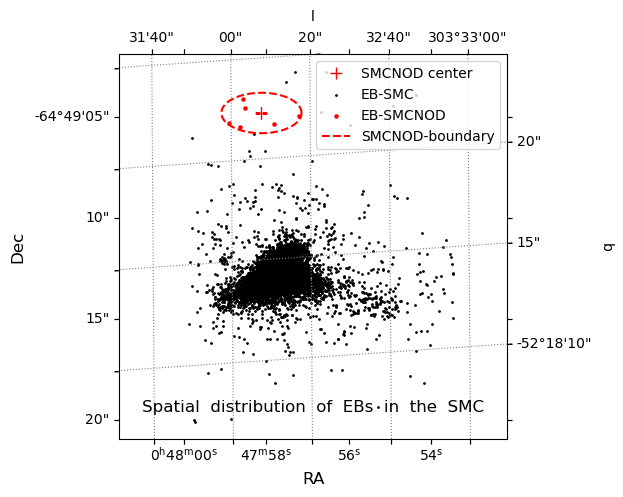

In [14]:
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(projection=wcs_helix_dict)
overlay = ax.get_coords_overlay('galactic')
overlay.grid(color='grey', ls='dotted')
plt.plot(RA, DEC,'+r',ms=8,label="SMCNOD center")
plt.scatter(EB['RA'],EB['Decl'],c='k',s=1,label='EB-SMC')
plt.scatter(EB_smcnod['RA'],EB_smcnod['Decl'],c='red',s=5,label='EB-SMCNOD')
plt.xlabel('RA', size=12)
plt.ylabel('Dec', size=12)
#plt.scatter(12, -64.8, s=3000, edgecolor='red', linestyle='dashed',facecolor='none',label='SMCNOD-boundary')
u=12.     #x-position of the center
v=-64.8    #y-position of the center
a=6.2    #radius on the x-axis
b=1.   #radius on the y-axis
t = np.linspace(0, 2*np.pi, 100)
plt.plot( u+a*np.cos(t) , v+b*np.sin(t) ,c='red',linestyle='dashed',label='SMCNOD-boundary')
plt.xlim(-10,50)
plt.legend(loc='upper right')
plt.title('Spatial  distribution  of  EBs  in  the  SMC',y=0.05)

## 1.2  Anomalous Cepheids
- Anomalous  Cepheids are  radial  pulsators with  rather  short  pulsation  periods  (ranging  from  a  fewhours up to two days). 
- The ACs are believed to be relatively massive (up to 2M), metal-deficient helium-burning stars. 
- They are often found in nearby dwarf galaxies, but their occurrence in globular clusters is very rare with one confirmed case. 
- The originof ACs is still unclear; there are two main hypotheses to explain them. 
- They may either be metal-poor intermediate-age(1 - 6 Gyr) stars or merged binary stars older than 10 Gyr.
- Importantly, they follow a P-L relation and can be used asstandard candles (Soszy ́nski et al. 2015b).

In [15]:
AC = pd.read_csv("Anomalous_Cepheids.txt", 
                   skiprows = 6,
                   header=0,
                   sep="\s+",
                   usecols=['#','ID','RA','Decl','I','V','V_I'],
                   on_bad_lines='skip')
AC = AC.rename(columns={'#': 'ID', 'ID': 'RA',"RA" :"Decl", 
                        "Decl":"I", "I":"V","V":"V_I", "V_I":"P_1"})

In [16]:
AC

,ID,RA,Decl,I,V,V_I,P_1
0,OGLE-SMC-ACEP-001,349.239045,-75.502500,17.535,18.097,0.562,0.921164
1,OGLE-SMC-ACEP-002,355.958955,-72.099333,17.730,18.331,0.601,1.225515
2,OGLE-SMC-ACEP-003,356.867670,-72.302944,17.570,17.997,0.427,1.080453
3,OGLE-SMC-ACEP-004,358.254000,-69.695556,18.313,18.912,0.599,0.838275
4,OGLE-SMC-ACEP-005,359.348880,-63.933778,17.682,18.215,0.533,1.140230
...,...,...,...,...,...,...,...
117,OGLE-SMC-ACEP-118,26.508045,-77.266278,17.807,18.297,0.490,0.654370
118,OGLE-SMC-ACEP-119,28.582035,-70.630806,18.280,18.671,0.391,0.547054
119,OGLE-SMC-ACEP-120,12.056085,-79.963556,17.981,18.316,0.335,0.506741
120,OGLE-SMC-ACEP-121,12.820005,-68.984278,17.718,18.265,0.547,0.994596


In [17]:
AC_smcnod = AC.loc[(AC['ID'] == 'OGLE-SMC-ACEP-016') | (AC['ID'] == 'OGLE-SMC-ACEP-027') | 
                   (AC['ID'] == 'OGLE-SMC-ACEP-031') | (AC['ID'] == 'OGLE-SMC-ACEP-034') ]

In [18]:
AC_smcnod

,ID,RA,Decl,I,V,V_I,P_1
15,OGLE-SMC-ACEP-016,7.553250,-64.695111,16.985,17.523,0.538,1.863798
26,OGLE-SMC-ACEP-027,9.832005,-64.907750,17.966,18.392,0.426,0.727920
30,OGLE-SMC-ACEP-031,10.121835,-64.937722,17.259,17.803,0.544,1.926161
33,OGLE-SMC-ACEP-034,10.248255,-65.060833,18.084,18.576,0.492,0.800210


Text(0.5, 0.05, 'Spatial  distribution  of  ACs  in  the  SMC')

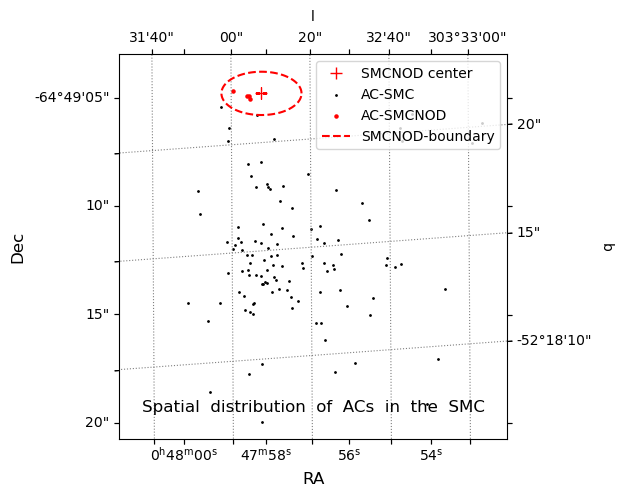

In [20]:
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(projection=wcs_helix_dict)
overlay = ax.get_coords_overlay('galactic')
overlay.grid(color='grey', ls='dotted')
plt.plot(RA, DEC,'+r',ms=8,label="SMCNOD center")
plt.scatter(AC['RA'],AC['Decl'],c='k',s=1,label='AC-SMC')
plt.scatter(AC_smcnod['RA'],AC_smcnod['Decl'],c='red',s=5,label='AC-SMCNOD')
plt.xlabel('RA', size=12)
plt.ylabel('Dec', size=12)
#plt.scatter(12, -64.8, s=3000, edgecolor='red', linestyle='dashed',facecolor='none',label='SMCNOD-boundary')
u=12.     #x-position of the center
v=-64.8    #y-position of the center
a=6.2    #radius on the x-axis
b=1.   #radius on the y-axis

t = np.linspace(0, 2*np.pi, 100)
plt.plot( u+a*np.cos(t) , v+b*np.sin(t) ,c='red',linestyle='dashed',label='SMCNOD-boundary')
plt.xlim(-10,50)
plt.legend(loc='upper right')
plt.title('Spatial  distribution  of  ACs  in  the  SMC',y=0.05)

## 1.3 Classical Cepheids

In [21]:
CC = pd.read_csv("classical_Cepheids.txt", 
                   skiprows = 6,
                   header=0,
                   sep="\s+",
                   usecols=['#','Mode','RA','Decl','I','V','V_I'],
                   on_bad_lines='skip')
CC= CC.rename(columns={'#': 'ID', 'Mode':'RA',"RA" :"Decl", "Decl":"I", "I":"V", "V":"V_I","V_I":"P_1"})

In [22]:
CC

,ID,RA,Decl,I,V,V_I,P_1
0,OGLE-SMC-CEP-0001,5.032785,-74.548500,17.314,17.897,0.583,1.128258
1,OGLE-SMC-CEP-0002,5.172375,-74.516222,16.690,17.230,0.540,1.135453
2,OGLE-SMC-CEP-0003,5.269125,-73.770917,16.997,17.437,0.440,0.956296
3,OGLE-SMC-CEP-0004,5.342745,-74.078639,17.294,17.679,0.385,0.517080
4,OGLE-SMC-CEP-0005,5.474505,-72.372972,17.196,17.768,0.572,1.287411
...,...,...,...,...,...,...,...
4946,OGLE-SMC-CEP-4991,10.567995,-71.910306,17.023,17.443,0.420,0.614595
4947,OGLE-SMC-CEP-4992,11.498415,-72.304944,18.864,19.315,0.451,0.233790
4948,OGLE-SMC-CEP-4993,11.965035,-74.664694,17.159,-99.990,-99.990,0.883136
4949,OGLE-SMC-CEP-4994,15.176745,-74.302278,16.554,16.975,0.421,0.847183


Text(0.5, 0.05, 'Spatial  distribution  of  CCs  in  the  SMC')

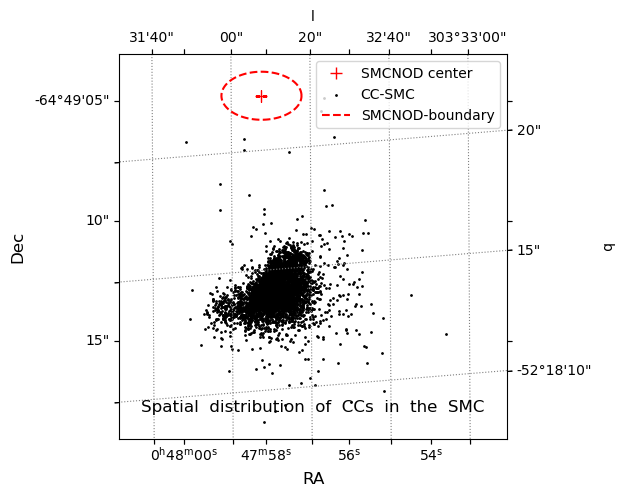

In [24]:
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(projection=wcs_helix_dict)
overlay = ax.get_coords_overlay('galactic')
overlay.grid(color='grey', ls='dotted')
plt.plot(RA, DEC,'+r',ms=8,label="SMCNOD center")
plt.scatter(CC['RA'],CC['Decl'],c='k',s=1,label='CC-SMC')
plt.xlabel('RA', size=12)
plt.ylabel('Dec', size=12)
#plt.scatter(12, -64.8, s=3000, edgecolor='red', linestyle='dashed',facecolor='none',label='SMCNOD-boundary')
u=12.     #x-position of the center
v=-64.8    #y-position of the center
a=6.2    #radius on the x-axis
b=1.   #radius on the y-axis

t = np.linspace(0, 2*np.pi, 100)
plt.plot( u+a*np.cos(t) , v+b*np.sin(t) ,c='red',linestyle='dashed',label='SMCNOD-boundary')
plt.xlim(-10,50)
plt.legend(loc='upper right')
plt.title('Spatial  distribution  of  CCs  in  the  SMC',y=0.05)

## 1.4 RR Lyrae stars (>9 Gyr)
- RR Lyrae stars are Population II stars, mostly radially pulsating  variables,  located  on  the  horizontal  branch  of  the Hertzsprung-Russell  diagram.  
- They  can  be  used  to  study stellar pulsations and evolution and are unambiguous indicators of populations older than 9 Gyr. 
- RR Lyrae stars are alsoexcellent distance indicators and thus can be used to studythe structure of the old population of the Milky Way andnearby galaxies.

In [25]:
RR = pd.read_csv("RR_Lyrae.txt", 
                   skiprows = 6,
                   header=0,
                   sep="\s+",
                   usecols=['#','ID','Type','RA','Decl','I','V','V_I'],
                   on_bad_lines='skip')
RR= RR.rename(columns={'#': 'ID', 'ID':'Type','Type':'RA',"RA" :"Decl", "Decl":"I", "I":"V", "V":"V_I","V_I":"P_1"})
RR = RR[RR['Type'] == 'RRab']

In [26]:
RR

,ID,Type,RA,Decl,I,V,V_I,P_1
0,OGLE-SMC-RRLYR-0001,RRab,4.977960,-74.701167,19.050,19.564,0.514,0.558814
1,OGLE-SMC-RRLYR-0002,RRab,4.978245,-74.558528,19.004,19.597,0.593,0.594794
2,OGLE-SMC-RRLYR-0003,RRab,5.071125,-71.957333,19.155,19.767,0.612,0.650679
4,OGLE-SMC-RRLYR-0005,RRab,5.091000,-74.383250,19.052,19.641,0.589,0.565265
5,OGLE-SMC-RRLYR-0006,RRab,5.138835,-74.732806,18.994,19.536,0.542,0.547184
...,...,...,...,...,...,...,...,...
6778,OGLE-SMC-RRLYR-6781,RRab,24.796170,-72.810111,18.860,-99.990,-99.990,0.631729
6779,OGLE-SMC-RRLYR-6782,RRab,25.115625,-66.253000,19.513,19.970,0.457,0.658465
6780,OGLE-SMC-RRLYR-6783,RRab,26.457660,-76.919111,19.393,19.674,0.281,0.614035
6782,OGLE-SMC-RRLYR-6785,RRab,28.192245,-78.125500,19.361,-99.990,-99.990,0.687487


In [27]:
RR_smcnod = RR.loc[(RR['ID'] == 'OGLE-SMC-RRLYR-3542') | (RR['ID'] == 'OGLE-SMC-RRLYR-3633') | 
                   (RR['ID'] == 'OGLE-SMC-RRLYR-3851') | (RR['ID'] == 'OGLE-SMC-RRLYR-3941') |
                  (RR['ID'] == 'OGLE-SMC-RRLYR-3973') | (RR['ID'] == 'OGLE-SMC-RRLYR-4054') |
                  (RR['ID'] == 'OGLE-SMC-RRLYR-4566') | (RR['ID'] == 'OGLE-SMC-RRLYR-4581') | 
                   (RR['ID'] == 'OGLE-SMC-RRLYR-4685') | (RR['ID'] == 'OGLE-SMC-RRLYR-4738') |
                  (RR['ID'] == 'OGLE-SMC-RRLYR-4777') | (RR['ID'] == 'OGLE-SMC-RRLYR-4960') |
                  (RR['ID'] == 'OGLE-SMC-RRLYR-4965')]

In [28]:
RR_smcnod

,ID,Type,RA,Decl,I,V,V_I,P_1
3539,OGLE-SMC-RRLYR-3542,RRab,8.788410,-64.838917,19.131,19.662,0.531,0.617970
3630,OGLE-SMC-RRLYR-3633,RRab,9.431415,-65.457806,19.300,19.989,0.689,0.562765
3848,OGLE-SMC-RRLYR-3851,RRab,10.961790,-64.441028,18.986,19.493,0.507,0.569543
3938,OGLE-SMC-RRLYR-3941,RRab,11.476455,-64.066444,14.037,14.438,0.401,0.473841
3970,OGLE-SMC-RRLYR-3973,RRab,11.737005,-64.804861,18.990,19.623,0.633,0.633637
4051,OGLE-SMC-RRLYR-4054,RRab,12.194955,-65.209722,19.105,19.679,0.574,0.625432
4563,OGLE-SMC-RRLYR-4566,RRab,15.551295,-65.459306,19.187,19.809,0.622,0.610555
4578,OGLE-SMC-RRLYR-4581,RRab,15.639705,-65.545417,18.945,19.532,0.587,0.626286
4682,OGLE-SMC-RRLYR-4685,RRab,16.243545,-64.848861,16.272,16.840,0.568,0.630632
4735,OGLE-SMC-RRLYR-4738,RRab,16.630035,-64.402500,19.253,19.756,0.503,0.645353


Text(0.5, 0.05, 'Spatial  distribution  of  RRs  in  the  SMC')

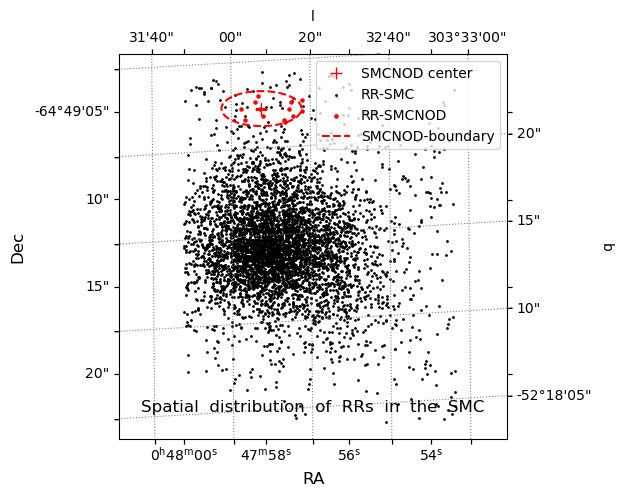

In [30]:
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(projection=wcs_helix_dict)
overlay = ax.get_coords_overlay('galactic')
overlay.grid(color='grey', ls='dotted')
plt.plot(RA, DEC,'+r',ms=8,label="SMCNOD center")
plt.scatter(RR['RA'],RR['Decl'],c='k',s=1,label='RR-SMC')
plt.scatter(RR_smcnod['RA'],RR_smcnod['Decl'],c='red',s=5,label='RR-SMCNOD')
plt.xlabel('RA', size=12)
plt.ylabel('Dec', size=12)
#plt.scatter(12, -64.8, s=3000, edgecolor='red', linestyle='dashed',facecolor='none',label='SMCNOD-boundary')
u=12.     #x-position of the center
v=-64.8    #y-position of the center
a=6.2    #radius on the x-axis
b=1.   #radius on the y-axis

t = np.linspace(0, 2*np.pi, 100)
plt.plot( u+a*np.cos(t) , v+b*np.sin(t) ,c='red',linestyle='dashed',label='SMCNOD-boundary')
plt.xlim(-10,50)
plt.legend(loc='upper right')
plt.title('Spatial  distribution  of  RRs  in  the  SMC',y=0.05)

In [31]:
# Load fits file
with fits.open('s5dr32_gdr3.fits') as hdu_list:
    table_S5 = table.Table(hdu_list[1].data)
# SMC Centre
RA_smc, DEC_smc = 13, -72.817
alpha_smc = np.radians(RA_smc)
delta_smc = np.radians(DEC_smc)
# SMCNOD Centre
RA, DEC = 12, -64.8 # deg
alpha1 = np.radians(RA)
delta1 = np.radians(DEC)
alpha2 = np.radians(table_S5['ra'])
delta2 = np.radians(table_S5['dec'])
angular_sep_rad = np.arccos(np.sin(delta1) * np.sin(delta2) + \
                            np.cos(delta1) * np.cos(delta2) * np.cos(alpha1 - alpha2))
# Radius cut
cut_r = 1.05 # deg
sel_radius = np.degrees(angular_sep_rad) < cut_r
table_cut = table_S5[sel_radius]
# Quality cut
c1 = table_cut['best_sn_1700d'] > 4
c2 = table_cut['best_sn_580v'] > 4
c3 = table_cut['good_star_pb'] > 0.5
c4 = table_cut['vel_calib_std'] < 10
c5 = table_cut["feh_calib_std"] < 0.5
high_quality = (c1 | c2) & c3 & c4
table_cut = table_cut[high_quality]

In [32]:
sel_peak = (60 <table_cut['vel_calib']) & (table_cut['vel_calib'] < 125.5)
peak_pm = ( 0 < table_cut['pmra'][sel_peak] ) & ( table_cut['pmra'][sel_peak] < 1.5) & (-1.75 < table_cut['pmdec'] [sel_peak]) & (table_cut['pmdec'] [sel_peak] < -0.6)
# cut
g_band = table_cut['decam_g'] - 3.185 * table_cut['ebv']
r_band = table_cut['decam_r'] - 2.140 * table_cut['ebv']
i_band = table_cut['decam_i'] - 1.569 * table_cut['ebv']
g_cut = table_cut['decam_g'][sel_peak][peak_pm] - 3.185 * table_cut['ebv'][sel_peak][peak_pm]
r_cut = table_cut['decam_r'][sel_peak][peak_pm] - 2.140 * table_cut['ebv'][sel_peak][peak_pm]
i_cut = table_cut['decam_i'][sel_peak][peak_pm] - 1.569 * table_cut['ebv'][sel_peak][peak_pm]
# isochrone
# Dotter/Dartmouth isochrone
# intermediate-age stars, age = 6Gyr, z = 0.001
# here Z is the abundances of elements other than X and Y which is H and He
table_iso = ascii.read('iso_a06.0_z0.00108.dat', header_start = 8)
g_iso = table_iso['DECam_g']
r_iso = table_iso['DECam_r']
i_iso = table_iso['DECam_i']
# 18.96 ± 0.02 distance modulus in kpc
u_dm = 18.96

In [33]:
table_iso

EEP,M/Mo,LogTeff,LogG,LogL/Lo,DECam_u,DECam_g,DECam_r,DECam_i,DECam_z,DECam_Y
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
9,0.105524,3.5212,5.3398,-2.8402,16.5006,14.3108,12.8187,11.713,11.2965,11.1815
10,0.117986,3.5251,5.2832,-2.7197,16.1173,13.9424,12.4596,11.4064,11.0006,10.886
11,0.132957,3.5293,5.225,-2.5929,15.7102,13.5553,12.0837,11.0839,10.6892,10.575
12,0.153655,3.5353,5.1681,-2.4494,15.2349,13.1041,11.6477,10.7162,10.3369,10.2239
13,0.181755,3.5441,5.1219,-2.2955,14.6988,12.5961,11.1615,10.3179,9.9605,9.8506
14,0.207528,3.5511,5.0873,-2.175,14.2814,12.2044,10.7895,10.0076,9.6665,9.5597
15,0.228001,3.5556,5.0617,-2.09,13.9943,11.9348,10.5333,9.7896,9.4589,9.3542
16,0.245517,3.5589,5.0413,-2.0239,13.7744,11.7284,10.3374,9.6206,9.2974,9.1943
17,0.262833,3.5619,5.024,-1.9652,13.5814,11.5466,10.1644,9.4707,9.154,9.0525


In [34]:
def getGV(BP_RP):
    G_V = -0.02704+0.01424*(BP_RP)-0.2156*((BP_RP)**2)+0.01426*((BP_RP)**3)
    return G_V

In [35]:
BP_RP = table_cut['phot_bp_mean_mag']-table_cut['phot_rp_mean_mag']
BP_RP_cut = table_cut['phot_bp_mean_mag'][sel_peak][peak_pm]-table_cut['phot_rp_mean_mag'][sel_peak][peak_pm]

In [36]:
G_V = getGV(BP_RP)
G_V_cut = getGV(BP_RP_cut)
v_band = -G_V + table_cut['phot_g_mean_mag']
v_cut = -G_V_cut + table_cut['phot_g_mean_mag'][sel_peak][peak_pm]

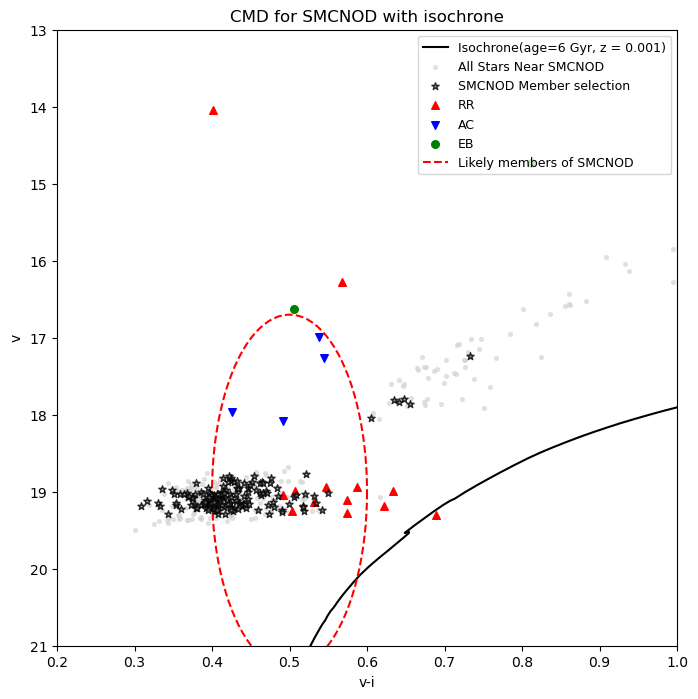

In [37]:
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(g_iso - r_iso, g_iso + u_dm, '-k', label = 'Isochrone(age=6 Gyr, z = 0.001)')
plt.scatter(v_band - i_band, i_band,marker='.', s=30, c='lightgray', zorder=1, alpha=0.6,label='All Stars Near SMCNOD')
plt.scatter(v_cut - i_cut, i_cut, marker='*', s=30, c='gray', ec='k', zorder=3, alpha=0.8, label='SMCNOD Member selection')

#ax.plot(g_cut - r_cut, g_cut, 'or', mec='k', label = "Peak selection")
plt.scatter(RR_smcnod['V_I'],RR_smcnod['I'],c='red',s=30,marker='^',label='RR')
ax.scatter(AC_smcnod['V_I'],AC_smcnod['I'],c='blue',s=30,marker='v',label='AC')
ax.scatter(EB_smcnod['V'] - EB_smcnod['I'], EB_smcnod['I'],c='green',s=30,marker='o',label='EB')
from math import pi

u=0.5     #x-position of the center
v=19   #y-position of the center
a=0.1    #radius on the x-axis
b=2.3   #radius on the y-axis

t = np.linspace(0, 2*pi, 100)
plt.plot(u+a*np.cos(t) , v+b*np.sin(t), c='red',linestyle='dashed',label = 'Likely members of SMCNOD')

ax.set_xlim(0.2,1.0)
ax.set_ylim(13,21)
ax.set_xlabel('v-i')
ax.set_ylabel('v')
ax.invert_yaxis()
plt.title('CMD for SMCNOD with isochrone')
ax.legend(loc='upper right',fontsize=9)
plt.show()

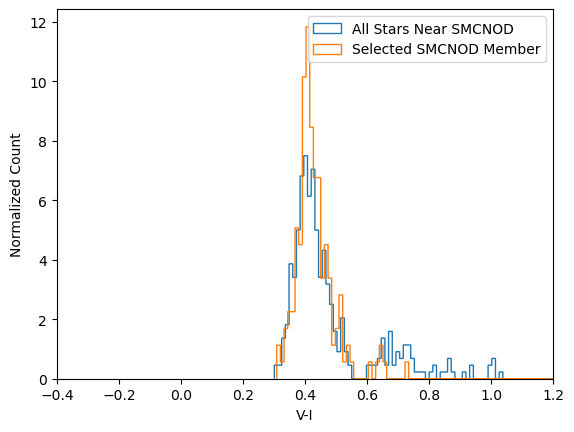

In [38]:
plt.hist(v_band-i_band,histtype="step", density=True,bins=10000,label='All Stars Near SMCNOD')
plt.hist(v_cut - i_cut,histtype="step", density=True,bins=10000,label='Selected SMCNOD Member')
#plt.hist(RR_smcnod['V_I'],histtype="step", density=True,bins=10,label='Selected SMCNOD RR')
#plt.hist(AC_smcnod['V_I'],histtype="step", density=True,bins=3,label='Selected SMCNOD AC')
plt.xlabel('V-I')
plt.ylabel('Normalized Count')
plt.xlim(-0.4,1.2)
plt.legend()

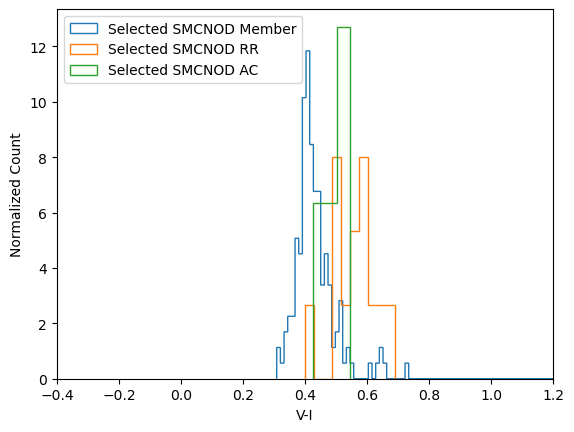

In [132]:
plt.hist(v_cut - i_cut,histtype="step", density=True,bins=10000,label='Selected SMCNOD Member')
plt.hist(RR_smcnod['V_I'],histtype="step", density=True,bins=10,label='Selected SMCNOD RR')
plt.hist(AC_smcnod['V_I'],histtype="step", density=True,bins=3,label='Selected SMCNOD AC')
plt.xlabel('V-I')
plt.ylabel('Normalized Count')
plt.xlim(-0.4,1.2)
plt.legend()
plt.savefig('cmd.png')

In [48]:
# objective peak selection for member
metalpoor = table_cut['feh50'] < -1.5
sel_peak = (60 <table_cut['vel_calib']) & (table_cut['vel_calib'] < 125.5)
peak_pm = ( 0 < table_cut['pmra'][sel_peak] )  &  ( table_cut['pmra'][sel_peak] < 1.5) & (-1.75 < table_cut['pmdec'] [sel_peak]) & (table_cut['pmdec'] [sel_peak] < -0.6)
smcnod = table_cut[sel_peak][peak_pm]
tab = table_cut
tab_1 = smcnod

In [49]:
pgal = 0.471
pbg1 = 0.571
vhel = 102.296
lsigv = 1.380
feh = -1.900
lsigfeh = -0.516
vbg1 = 140.157
lsigvbg1 = 1.967
fehbg1 = -1.305
lsigfeh1 = -0.373
vbg2 = 27.487
lsigvbg2 = 1.626
fehbg2 = -0.681
lsigfeh2 = -0.498
pmra1 = 0.703
pmdec1 = -1.123

theta_opt = pgal, pbg1, vhel, lsigv, feh, lsigfeh, vbg1, lsigvbg1, fehbg1, lsigfeh1, vbg2, lsigvbg2, fehbg2, lsigfeh2, pmra1, pmdec1
# heliocentric radial velocity
rv = tab["vel_calib"]
rverr = tab["vel_calib_std"]
# metallicity
feh = tab["feh50"]
feherr = tab["feh_calib_std"]
# proper motions
pmra = tab["pmra"]
pmraerr = tab["pmra_error"]
pmdec = tab["pmdec"]
pmdecerr = tab["pmdec_error"]

N = len(tab)
# Create 2-D arrays for proper motion
pms = np.zeros((N,2)) # Return a new array of given shape (150,2)
pms[:,0] = tab["pmra"]
pms[:,1] = tab["pmdec"]
# assume uniform background
pmmax = np.max(np.sqrt(np.sum(pms**2, axis=1)))
pmnorm = 1/(np.pi * pmmax**2)
# Covariance Matrix
pmcovs = np.zeros((N,2,2))
pmcovs[:,0,0] = tab["pmra_error"]**2
pmcovs[:,1,1] = tab["pmdec_error"]**2
pmcovs[:,0,1] = tab["pmra_error"]*tab["pmdec_error"]*tab["pmra_pmdec_corr"]
pmcovs[:,1,0] = tab["pmra_error"]*tab["pmdec_error"]*tab["pmra_pmdec_corr"]
data = dict(N=len(tab), pms=pms, pmcovs=pmcovs, pmnorm=pmnorm)

In [50]:
def memprob(theta,rv, rverr, feh, feherr):
    pgal, pbg1, \
    vhel, lsigv, feh0, lsigfeh, \
    vbg1, lsigvbg1, fehbg1, lsigfeh1, \
    vbg2, lsigvbg2, fehbg2, lsigfeh2, \
    pmra_gal, pmdec_gal = theta
    pm0s = np.zeros((N,2))
    pm0s[:,0] = pmra_gal
    pm0s[:,1] = pmdec_gal
    #lgal
    ## Compute log likelihood in rv
    lgal_vhel = stats.norm.logpdf(rv, loc=vhel, scale=np.sqrt(rverr**2 + (10**lsigv)**2))    
    ## Compute log likelihood in feh
    lgal_feh = stats.norm.logpdf(feh, loc=feh, scale=np.sqrt(feherr**2 + (10**lsigfeh)**2)) 
    ## Compute log likelihood in pm
    lgal_pm = [stats.multivariate_normal.logpdf(pms[i], mean=pm0s[i], cov=pmcovs[i]) for i in range(N)]    
    ## Combine the components
    lgal = np.log(pgal) + lgal_vhel + lgal_feh + lgal_pm
    ## exp of log
    gal = 10**lgal
    
    ## bg1
    lbg1_vhel = stats.norm.logpdf(rv, loc=vbg1, scale=np.sqrt(rverr**2 + (10**lsigvbg1)**2))   
    lbg1_feh = stats.norm.logpdf(feh, loc=fehbg1, scale=np.sqrt(feherr**2 + (10**lsigfeh1)**2))
    lbg1_pm = np.log(data["pmnorm"])
    ## Combine the components
    lbg1 = np.log(pbg1) + lbg1_vhel + lbg1_feh + lbg1_pm
    
    # bg2
    lbg2_vhel = stats.norm.logpdf(rv, loc=vbg2, scale=np.sqrt(rverr**2 + (10**lsigvbg2)**2))
    lbg2_feh = stats.norm.logpdf(feh, loc=fehbg2, scale=np.sqrt(feherr**2 + (10**lsigfeh2)**2))
    lbg2_pm = np.log(data["pmnorm"])
    lbg2 = np.log(1-pbg1) + lbg2_vhel + lbg2_feh + lbg2_pm
    
    # combine bg1 and bg2
    lbgtot = np.logaddexp(lbg1, lbg2)
    bg = 10**lbgtot
    
    # member probability
    p = (gal*pgal)/((gal*pgal)+(1-pgal)*bg)
    return p

In [51]:
tab['memberprob'] = memprob(theta_opt,tab['vel_calib'],tab['vel_calib_std'],tab['feh50'],tab['feh_std'])
tab['membership'] = memprob(theta_opt,tab['vel_calib'],tab['vel_calib_std'],tab['feh50'],tab['feh_std']) > 0.5
unique_star = tab[(0.5 < tab['memberprob']) & (tab['memberprob'] < 0.999)]
tab_good = tab[tab['memberprob'] > 0.95]

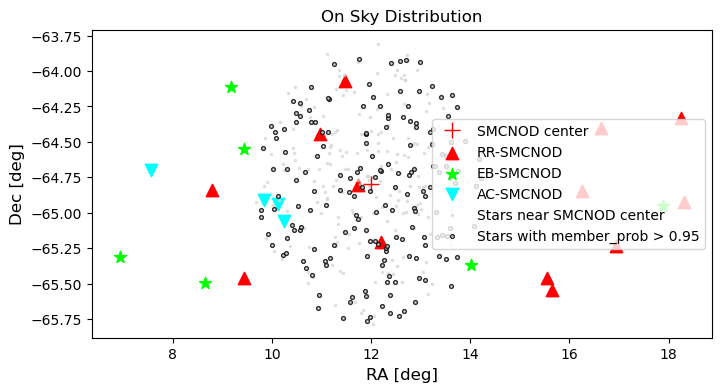

In [137]:
fig, ax = plt.subplots(figsize = (8,4))
plt.plot(RA, DEC,'+r',ms=12,label="SMCNOD center")
# variable stars
plt.scatter(RR_smcnod['RA'],RR_smcnod['Decl'],marker='^',c='red',s=80,label='RR-SMCNOD')
plt.scatter(EB_smcnod['RA'],EB_smcnod['Decl'],marker='*',c='lime',s=80,label='EB-SMCNOD')
plt.scatter(AC_smcnod['RA'],AC_smcnod['Decl'],marker='v',c='cyan',s=80,label='AC-SMCNOD')


plt.scatter(tab['ra'],tab['dec'],marker='.', s=10, c='lightgray', zorder=1, alpha=0.6,label='Stars near SMCNOD center')
plt.scatter(tab_good['ra'],tab_good['dec'], marker='.', s=30, c='lightgray', ec='k', zorder=3, alpha=0.8,
        label='Stars with member_prob > 0.95')



plt.xlabel('RA [deg]', size=12)
plt.ylabel('Dec [deg]', size=12)
plt.title('On Sky Distribution')
plt.legend(loc='center right', bbox_to_anchor=(1, 0.5))
plt.savefig('variablestarsky.png')